In [1]:
import cython
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pymc3 as pm

from theano import scan
import theano.tensor as tt

from pymc3.distributions import continuous
from pymc3.distributions import distribution

%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255
x_test  = x_test/255

def subset(label, data=x_train, labels=y_train):
    '''
    e.g. subset(3) -> gets all pictures of digit 3
    '''
    assert label >= 0 and label <= 9
    
    return data[np.argwhere(labels == 3)]

In [3]:
def plot(image, figsize=(16, 7)):
    
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='Greys')
    

def plot_many():
    pass

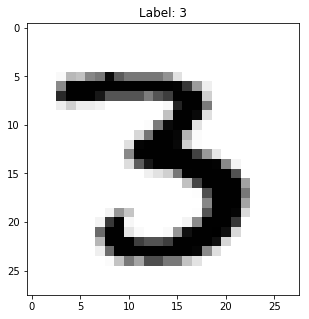

In [4]:
dummy = x_train[12]
plot(dummy, figsize=(10, 5))
_ = plt.title('Label: ' + str(y_train[12]))

In [5]:
O = np.concatenate(dummy)

Taken from https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html

In [83]:
adj = []
position_matrix = np.linspace(0, 28*28 - 1, num=28*28).astype(np.int64).reshape(28, 28)
count = 0

for i, row in enumerate(position_matrix):
    for j, col in enumerate(position_matrix[i]):
        assert position_matrix[i][j] == col
        
        temp = []

        # change these loops if we do not want to
        # include diagonal elements in adj matrix
        for delta_i in [-1, 0, 1]:
            for delta_j in [-1, 0, 1]:
                if ((i + delta_i) // 28 == 0) and ((j + delta_j) // 28 == 0):    
                    temp.append(position_matrix[i + delta_i][j + delta_j])
        

        temp.remove(col)
        temp.sort()
        adj.append(temp)
        
weights = [list(np.ones_like(adj_elems).astype(np.int64)) for adj_elems in adj]

# below is taken from the pymc3 CAR tutorial website
maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat2 = np.zeros((N, N))
amat2 = np.zeros((N, N), dtype='int32')
for i, a in enumerate(adj):
    amat2[i, a] = 1
    wmat2[i, a] = weights[i]

In [84]:
class CAR2(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    a : adjacency matrix
    w : weight matrix
    tau : precision at each location
    
    Note that tau = 1/sigma^2
    """

    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR2, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.

    def logp(self, x):
        tau = self.tau
        w = self.w
        a = self.a

        mu_w = tt.sum(x*a, axis=1)/tt.sum(w, axis=1)
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))

In [94]:
with pm.Model() as model:
    beta0  = pm.Normal('beta0', mu=0., tau=1e-2)
    tau    = pm.Gamma('tau_c', alpha=1.0, beta=1.0)
    mu_phi = CAR2('mu_phi', w=wmat2, a=amat2, tau=tau, shape=N)
    phi    = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi)) # zero-center phi
    
    mu = pm.Deterministic('mu', beta0 + phi)
    Yi = pm.LogitNormal('Yi', mu=mu, observed=pad(O))
    
    trace = pm.sample(draws=1000)
    posterior_pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_phi, tau_c, beta0]
Sampling 2 chains: 100%|██████████| 3000/3000 [09:00<00:00,  5.55draws/s]  
The acceptance probability does not match the target. It is 0.7071954697612641, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6039659248878058, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 2000/2000 [00:01<00:00, 1974.66it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c5bbfa358>,
      dtype=object)

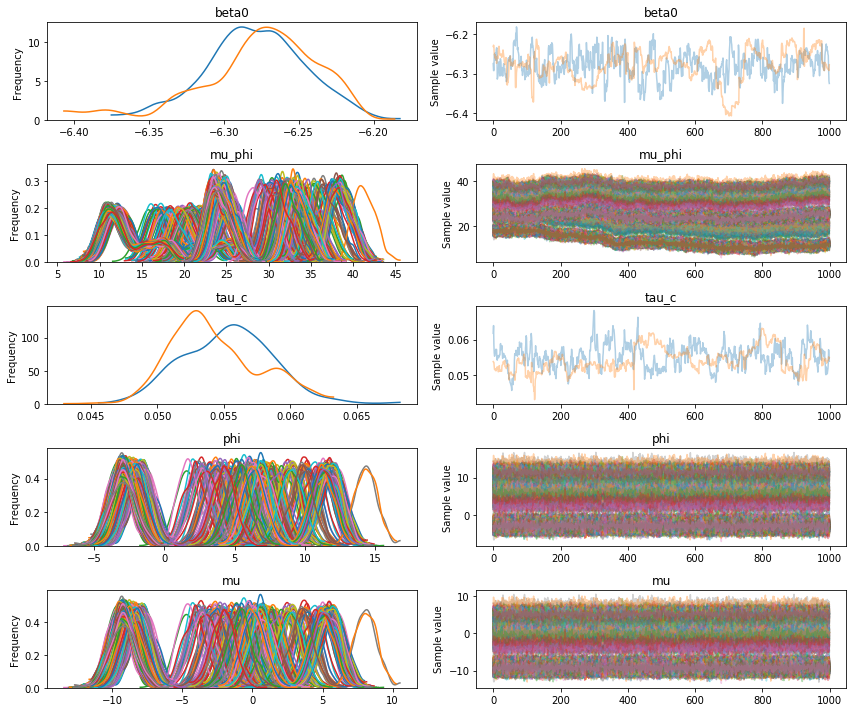

In [126]:
pm.traceplot(trace)

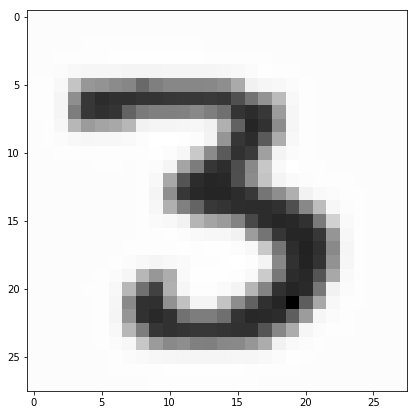

In [134]:
plot(np.mean(trace.get_values('phi'), axis=0).reshape(28, 28))